In [1]:
from csv import DictReader


with open("schweidtmann_train.csv", "r") as csv_file:
    reader = DictReader(csv_file)
    rows_train = [r for r in reader]
csv_file.close()

with open("schweidtmann_test.csv", "r") as csv_file:
    reader = DictReader(csv_file)
    rows_test = [r for r in reader]
csv_file.close()

print(len(rows_train), len(rows_test))

430 75


In [2]:
import torch


smiles_train, ron_train = [], []
smiles_test, ron_test = [], []

for sample in rows_train:
    if sample["Meas RON"] != "n.a.":
        smiles_train.append(sample[" SMILES"])
        ron_train.append([float(sample["Meas RON"])])

for sample in rows_test:
    if sample["Meas RON"] != "n.a.":
        smiles_test.append(sample[" SMILES"])
        ron_test.append([float(sample["Meas RON"])])

print(len(smiles_train), len(smiles_test))
print(len(ron_train), len(ron_test))

ron_train = torch.tensor(ron_train)
ron_test = torch.tensor(ron_test)

print(ron_train.shape, ron_test.shape)

284 51
284 51
torch.Size([284, 1]) torch.Size([51, 1])


In [3]:
from graphchem.data import MoleculeGraph, MoleculeDataset
from graphchem.preprocessing import MoleculeEncoder


encoder = MoleculeEncoder(smiles_train)

encoding_train = encoder.encode_many(smiles_train)
encoding_test = encoder.encode_many(smiles_test)

graphs_train = [MoleculeGraph(e[0], e[1], e[2], ron_train[i]) for i, e in enumerate(encoding_train)]
graphs_test = [MoleculeGraph(e[0], e[1], e[2], ron_test[i]) for i, e in enumerate(encoding_test)]

ds_train = MoleculeDataset(graphs_train)
ds_test = MoleculeDataset(graphs_test)

print(len(ds_train), len(ds_test))

284 51


In [4]:
from graphchem.nn import MoleculeGCN
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from copy import deepcopy


train_loader = DataLoader(ds_train, batch_size=16, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=1, shuffle=False)

atom_vocab_size, bond_vocab_size = encoder.vocab_sizes

model = MoleculeGCN(
    atom_vocab_size,
    bond_vocab_size,
    1,
    embedding_dim=64,
    n_messages=3,
    n_readout=3,
    readout_dim=64,
    p_dropout=0.0
)

init_lr = 0.001
lr_decay = 1e-7
optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

train_losses = []
test_losses = []

_lowest_loss = 1e10
_best_weights = None
_best_epoch = 0

model.train()
for epoch in range(500):

    for g in optimizer.param_groups:
        g["lr"] = max(0, init_lr - (epoch * lr_decay))

    train_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        pred, _, _ = model(batch)
        loss = F.mse_loss(pred, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().item()
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    test_loss = 0.0
    for batch in test_loader:
        pred, _, _ = model(batch)
        loss = F.mse_loss(pred, batch.y)
        test_loss += loss.detach().item()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    if test_loss < _lowest_loss:
        _lowest_loss = test_loss
        _best_weights = deepcopy(model.state_dict())
        _best_epoch = epoch

    if epoch % 10 == 0:
        print(f"{epoch}: {train_loss} | {test_loss} | {_lowest_loss}")

model.load_state_dict(_best_weights)

model.eval()


0: 300.3148653272172 | 1029.385557542829 | 1029.385557542829
10: 65.67316759136361 | 522.8197246112076 | 522.8197246112076
20: 36.82005422887668 | 380.8886791678036 | 380.8886791678036
30: 30.124542128871862 | 371.82166024209937 | 283.1944380776555
40: 24.796251431317398 | 495.0136153043485 | 240.14159862636063
50: 15.71417615111445 | 233.8098018888165 | 196.75815279204764
60: 12.125532956190511 | 219.83511942099122 | 161.01500563948946
70: 21.291688113145426 | 278.54819633278487 | 153.76700414351973
80: 11.073845339493014 | 299.4027000735788 | 129.08640490406577
90: 9.287165158231494 | 130.7396995542096 | 118.0634769491541
100: 10.920556551973585 | 132.68329169338242 | 118.0634769491541
110: 10.18457947314625 | 161.36103753336505 | 117.30172596294798
120: 6.383810567184233 | 124.05488518037487 | 108.41567955517174
130: 5.5437478078922755 | 131.51085641366595 | 102.08169230187366
140: 4.840369143956144 | 115.11991040436003 | 102.08169230187366
150: 4.7831035802062125 | 122.250410976509

MoleculeGCN(
  (emb_atom): Embedding(49, 64)
  (emb_bond): Embedding(34, 64)
  (atom_conv): GeneralConv(64, 64)
  (bond_conv): EdgeConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
  ))
  (readout): ModuleList(
    (0-2): 3 x Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
    )
    (3): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

<Figure size 640x480 with 0 Axes>

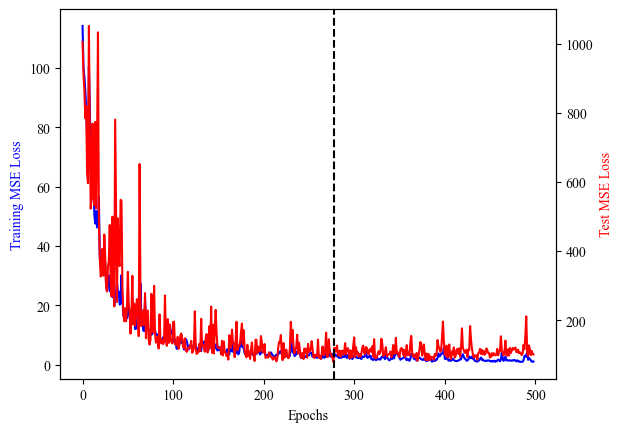

In [5]:
from matplotlib import pyplot as plt


plt.clf()
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots()
ax.plot([i for i in range(len(train_losses[1:]))], train_losses[1:], color="blue")
ax.set_xlabel("Epochs")
ax.set_ylabel("Training MSE Loss", color="blue")
ax2 = ax.twinx()
ax2.plot([i for i in range(len(test_losses[1:]))], test_losses[1:], color="red")
ax2.set_ylabel("Test MSE Loss", color="red")
ax2.axvline(x=_best_epoch, color="black", linestyle="--")
plt.show()

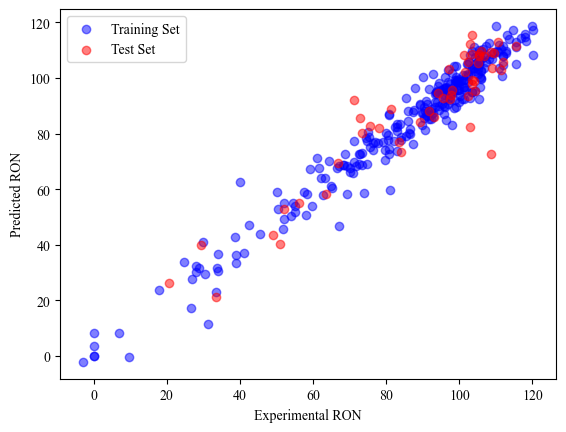

In [6]:
pred_train = [model(mol)[0].detach().numpy() for mol in ds_train]
pred_test = [model(mol)[0].detach().numpy() for mol in ds_test]
exp_train = [mol.y.numpy() for mol in ds_train]
exp_test = [mol.y.numpy() for mol in ds_test]

plt.clf()
plt.rcParams["font.family"] = "Times New Roman"
plt.scatter(exp_train, pred_train, color="blue", label="Training Set", alpha=0.5)
plt.scatter(exp_test, pred_test, color="red", label="Test Set", alpha=0.5)
plt.xlabel("Experimental RON")
plt.ylabel("Predicted RON")
plt.legend(loc="upper left")
plt.show()

In [7]:
from sklearn.metrics import mean_absolute_error, r2_score


e_test = [e[0] for e in exp_test]
p_test = [p[0] for p in pred_test]

print(f"Test MAE: {mean_absolute_error(e_test, p_test)}")
print(f"Test R2: {r2_score(e_test, p_test)}")

Test MAE: 6.524505764830346
Test R2: 0.8509000273173078
